In [12]:
from dotenv import load_dotenv
import os

load_dotenv()

PINECONE_API_KEY = os.environ['PINECONE_API_KEY']

In [13]:
# index 생성

In [14]:
# pip install Pinecone

In [15]:
from pinecone import Pinecone
# 클라이언트 생성
pinecone_client = Pinecone(api_key=PINECONE_API_KEY)

In [16]:
pinecone_client

In [17]:
from pinecone import ServerlessSpec
pinecone_client.create_index(
    name='embedding-3d',
    dimension=3,
    metric='cosine',
    spec=ServerlessSpec(cloud='aws', # 서버없이 
    region='us-east-1'
    )
)

PineconeApiException: (409)
Reason: Conflict
HTTP response headers: HTTPHeaderDict({'content-type': 'text/plain; charset=utf-8', 'access-control-allow-origin': '*', 'vary': 'origin,access-control-request-method,access-control-request-headers', 'access-control-expose-headers': '*', 'x-pinecone-api-version': '2025-04', 'x-cloud-trace-context': '863fdf2bbe2717d8798d3015958655f2', 'date': 'Tue, 09 Sep 2025 01:27:12 GMT', 'server': 'Google Frontend', 'Content-Length': '85', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'})
HTTP response body: {"error":{"code":"ALREADY_EXISTS","message":"Resource  already exists"},"status":409}


In [18]:
index = pinecone_client.Index('embedding-3d')
index

c:\Users\Admin\miniconda3\envs\prompting_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
index.describe_index_stats()

{'dimension': 3,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'embedding-3d-ns1': {'vector_count': 6}},
 'total_vector_count': 6,
 'vector_type': 'dense'}

# pinecone data 형식, 
[{ 'id' : 'vec1' , 'values' :[1.0, 1.5, 2.0] , 'metadata' : {'genre':'drama'}},
    { 'id' : 'vec2' , 'values' :[2.0, 1.5, 0.5] , 'metadata' : {'genre':'action'}},
    { 'id' : 'vec3' , 'values' :[0.1, 0.3, 0.5] , 'metadata' : {'genre':'drama'}},
    { 'id' : 'vec4' , 'values' :[1.0, 2.5, 3.5] , 'metadata' : {'genre':'action'}},
    { 'id' : 'vec5' , 'values' :[3.0, 1.2, 1.3] , 'metadata' : {'genre':'action'}},
    { 'id' : 'vec6' , 'values' :[0.3, 1.1, 2.5] , 'metadata' : {'genre':'drama'}},
    ]

In [20]:
for ids in index.list(namespace='embedding-3d-nsl'):
    print(ids)

In [21]:
# update+insert  없으면 insert 아니면 update
index.upsert(
  vectors=[{ 'id' : 'vec1' , 'values' :[1.0, 1.5, 2.0] , 'metadata' : {'genre':'drama'}},
    { 'id' : 'vec2' , 'values' :[2.0, 1.5, 0.5] , 'metadata' : {'genre':'action'}},
    { 'id' : 'vec3' , 'values' :[0.1, 0.3, 0.5] , 'metadata' : {'genre':'drama'}},
    { 'id' : 'vec4' , 'values' :[1.0, 2.5, 3.5] , 'metadata' : {'genre':'action'}},
    { 'id' : 'vec5' , 'values' :[3.0, 1.2, 1.3] , 'metadata' : {'genre':'action'}},
    { 'id' : 'vec6' , 'values' :[0.3, 1.1, 2.5] , 'metadata' : {'genre':'drama'}},
    ],
  namespace='embedding-3d-ns1'
  )

{'upserted_count': 6}

In [22]:
index.describe_index_stats()

{'dimension': 3,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'embedding-3d-ns1': {'vector_count': 6}},
 'total_vector_count': 6,
 'vector_type': 'dense'}

In [23]:
# id list

In [24]:
for ids in index.list(namespace='embedding-3d-ns1'):
    print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


In [25]:
# query

In [26]:
response = index.query(
    namespace='embedding-3d-ns1',
    vector=[0.1,0.2,0.4],
    top_k=3, # 많이 가져온다고 좋은 거 아님
    include_values=True,
    include_metadata=True,
    filter={'genre':{'$eq':'drama'}}
)
response

{'matches': [{'id': 'vec3',
              'metadata': {'genre': 'drama'},
              'score': 0.99648869,
              'values': [0.1, 0.3, 0.5]},
             {'id': 'vec6',
              'metadata': {'genre': 'drama'},
              'score': 0.993093967,
              'values': [0.3, 1.1, 2.5]},
             {'id': 'vec1',
              'metadata': {'genre': 'drama'},
              'score': 0.972847,
              'values': [1.0, 1.5, 2.0]}],
 'namespace': 'embedding-3d-ns1',
 'usage': {'read_units': 1}}

In [27]:
response = index.query(
  #namespace='embedding-3d-ns1',
  vector=[0.1, 0.4, 0.7], #질의 벡터
  top_k=3, #몇개 결과
  include_values=True,
  include_metadata=True,
  filter={'genre':{'$eq':'drama'}}
)
response

{'matches': [], 'namespace': '', 'usage': {'read_units': 1}}

In [28]:
ns = 'embedding-3d-ns1'
for ids in index.list(namespace=ns):
  print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


In [29]:
# fetch

In [30]:
from itertools import chain
all_ids = list(chain.from_iterable(index.list(namespace=ns)))
resp = index.fetch(ids=all_ids, namespace=ns)
resp

FetchResponse(namespace='embedding-3d-ns1', vectors={'vec1': Vector(id='vec1', values=[1.0, 1.5, 2.0], metadata={'genre': 'drama'}, sparse_values=None), 'vec4': Vector(id='vec4', values=[1.0, 2.5, 3.5], metadata={'genre': 'action'}, sparse_values=None), 'vec6': Vector(id='vec6', values=[0.3, 1.1, 2.5], metadata={'genre': 'drama'}, sparse_values=None), 'vec2': Vector(id='vec2', values=[2.0, 1.5, 0.5], metadata={'genre': 'action'}, sparse_values=None), 'vec3': Vector(id='vec3', values=[0.1, 0.3, 0.5], metadata={'genre': 'drama'}, sparse_values=None), 'vec5': Vector(id='vec5', values=[3.0, 1.2, 1.3], metadata={'genre': 'action'}, sparse_values=None)}, usage={'read_units': 1})

In [31]:
resp.vectors



{'vec1': Vector(id='vec1', values=[1.0, 1.5, 2.0], metadata={'genre': 'drama'}, sparse_values=None),
 'vec4': Vector(id='vec4', values=[1.0, 2.5, 3.5], metadata={'genre': 'action'}, sparse_values=None),
 'vec6': Vector(id='vec6', values=[0.3, 1.1, 2.5], metadata={'genre': 'drama'}, sparse_values=None),
 'vec2': Vector(id='vec2', values=[2.0, 1.5, 0.5], metadata={'genre': 'action'}, sparse_values=None),
 'vec3': Vector(id='vec3', values=[0.1, 0.3, 0.5], metadata={'genre': 'drama'}, sparse_values=None),
 'vec5': Vector(id='vec5', values=[3.0, 1.2, 1.3], metadata={'genre': 'action'}, sparse_values=None)}

In [ ]:
resp.vectors

In [32]:
for vid, v in resp.vectors.items():
  vid, v.values

In [ ]:
# page

In [33]:
for id_page in index.list(namespace=ns):
  print('*',id_page)
  resp = index.fetch(ids=id_page, namespace=ns)
  for vid, v in resp.vectors.items():
    print(vid, v.values)

* ['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']
vec5 [3.0, 1.2, 1.3]
vec4 [1.0, 2.5, 3.5]
vec1 [1.0, 1.5, 2.0]
vec6 [0.3, 1.1, 2.5]
vec2 [2.0, 1.5, 0.5]
vec3 [0.1, 0.3, 0.5]


In [34]:
# 새로운 쿼리벡터 추가하기


In [35]:
ids = list(resp.vectors.keys())
values = [vec.values for vec in resp.vectors.values()]

In [36]:
ids.append('qv')
values.append([0.1,0.3,0.7]) #dimension 일치

In [37]:
# 시각화 

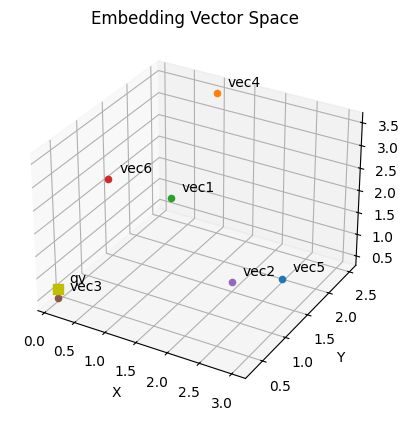

In [38]:
import matplotlib.pyplot as plt

# 3D 플롯을 생성합니다.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 각 벡터의 ID와 값을 사용하여 3D 공간에 점을 그립니다.
for i, id in enumerate(ids):
    if id == "qv":
        # 쿼리 벡터는 노란색 사각형으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id, color='y', s=50, marker='s')
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)
    else:
        # 나머지 벡터는 기본 색상으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id)
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)

# 축 레이블과 제목을 설정합니다.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Embedding Vector Space')

# 플롯을 표시합니다.
plt.show()

임베딩 미션   
name: "quickstart" 서버리스 인덱스 생성 dim: 1024,

In [ ]:
임베딩 모델 
multilingual-e5-large
upsert()
describe_index_stats()
query_vector

In [58]:
embeddings = pinecone_client.inference.embed(
    model='multilingual-e5-large',
    texts = [d['text'] for d in data],
    parameters={'input_type':'passage', 'truncate':'END'}
)
embeddings[0]

TypeError: Inference.embed() got an unexpected keyword argument 'texts'

In [ ]:
name: "quickstart" 서버리스 인덱스 생성 dim: 1024,

In [43]:
from pinecone import ServerlessSpec
pinecone_client.create_index(
  name='quickstart',
  dimension=1024,
  metric='cosine',
  spec=ServerlessSpec(
    cloud='aws',
    region='us-east-1'
  )
)

{
    "name": "quickstart",
    "metric": "cosine",
    "host": "quickstart-hba4a14.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 1024,
    "deletion_protection": "disabled",
    "tags": null
}

In [65]:
index = pinecone_client.Index('quickstart')
index

In [66]:
index.describe_index_stats()

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'quickstart': {'vector_count': 6}},
 'total_vector_count': 6,
 'vector_type': 'dense'}

In [67]:
for ids in index.list(namespace='embedding-3d-ns1'):
  print(ids)

In [68]:
data = [
    {"id": "vec1", "text": "사과는 달콤하고 아삭한 식감으로 유명한 인기 있는 과일입니다."},
    {"id": "vec2", "text": "애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다."},
    {"id": "vec3", "text": "많은 사람들이 건강한 간식으로 사과를 즐겨 먹습니다."},
    {"id": "vec4", "text": "애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 혁신했습니다."},
    {"id": "vec5", "text": "하루에 사과 하나면 의사를 멀리할 수 있다는 속담이 있습니다."},
    {"id": "vec6", "text": "애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, 로널드 웨인에 의해 파트너십으로 설립되었습니다."}
]

In [69]:
from pinecone import Pinecone
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('intfloat/multilingual-e5-large')



In [71]:
# 3. Pinecone 클라이언트 및 인덱스 연결
# 실제 API 키와 인덱스 이름으로 변경하세요.
index = pinecone_client.Index("quickstart")

# 4. 데이터를 Pinecone 'upsert' 형식에 맞게 변환
vectors_to_upsert = []
for item in data:
    # 텍스트를 벡터로 변환
    embedding = model.encode(item["text"]).tolist()
    
    # 'values' 필드에 벡터를, 'metadata'에 원본 텍스트를 저장
    vector_data = {
        "id": item["id"],
        "values": embedding,
        "metadata": {"text": item["text"]}
    }
    vectors_to_upsert.append(vector_data)

# 5. 'upsert()' 함수를 사용하여 데이터 업로드
# index.upsert_records() 대신 index.upsert()를 사용합니다.
index.upsert(
    vectors=vectors_to_upsert,
    namespace="quickstart"  # namespace는 동일하게 사용 가능
)

# 6. 결과 확인
print("데이터 업로드를 완료했습니다.")
print(index.describe_index_stats())

데이터 업로드를 완료했습니다.
{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'quickstart': {'vector_count': 6}},
 'total_vector_count': 6,
 'vector_type': 'dense'}


In [72]:
# 쿼리 텍스트를 정의합니다.
query = "애플이라는 기술 회사에 대해 알려주세요."

# 쿼리 텍스트를 임베딩 벡터로 변환합니다.
embedding = pinecone_client.inference.embed(
    model="multilingual-e5-large",
    inputs=[query],
    parameters={
        "input_type": "query"  # 입력 타입을 쿼리로 설정합니다.
    }
)

# 첫 번째 임베딩 벡터를 출력합니다.
print(embedding[0])

{'vector_type': dense, 'values': [0.0113525390625, -0.0175933837890625, ..., -0.02020263671875, -0.00698089599609375]}


In [80]:
# query 
results = index.query(
    namespace="quickstart",
    vector=embedding[0].values,
    top_k=3,
    include_values=False,
    include_metadata=True
)

# 검색 결과를 출력합니다.
print(results)

{'matches': [{'id': 'vec2',
              'metadata': {'text': '애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다.'},
              'score': 0.90089947,
              'values': []},
             {'id': 'vec4',
              'metadata': {'text': '애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 '
                                   '혁신했습니다.'},
              'score': 0.887853742,
              'values': []},
             {'id': 'vec6',
              'metadata': {'text': '애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, '
                                   '로널드 웨인에 의해 파트너십으로 설립되었습니다.'},
              'score': 0.866965055,
              'values': []}],
 'namespace': 'quickstart',
 'usage': {'read_units': 1}}
